## Baseline with a logistic regression

In [ ]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from xgboost import XGBClassifier
import imblearn.over_sampling

### Feature Engeenering

> Treating categorical variables

In [ ]:
df = pd.read_pickle('df.pkl')

In [105]:
df_2 = df.copy()

In [106]:
# In the particular feature, 'employment_status', there are two relevant categories so combining those as 'unemployed'.

df_2['employment_status'] = ['Unemployed' if status == 'Not in Labor Force' else status for status in df.employment_status]
df_2.employment_status.unique()

array(['Unemployed', 'Employed'], dtype=object)

In [107]:
# Treating ordinal variables to make sure that they are encoded in the correct orders.

education_lvl = [['< 12 Years','12 Years','College Graduate','Some College']]
age_lvl = [['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years']]
income_lvl = [['Below Poverty','<= $75,000, Above Poverty','> $75,000']]

transformer = make_column_transformer(
    (OrdinalEncoder(categories=education_lvl), ['education']),
    (OrdinalEncoder(categories=age_lvl), ['age_group']),
    (OrdinalEncoder(categories=income_lvl), ['income_poverty'])
)

transformer.fit_transform(df_2)

array([[0., 3., 0.],
       [1., 1., 0.],
       [2., 0., 1.],
       ...,
       [3., 3., 1.],
       [3., 0., 1.],
       [3., 4., 1.]])

In [108]:
# these are all ordinal variables that have incremental orders in each variables. 
variable= OrdinalEncoder()

ordinal.fit(df_2[['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk',
                'opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk',
                'opinion_seas_sick_from_vacc','household_adults','household_children','education','age_group']])

df_2[['h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk',
    'opinion_seas_sick_from_vacc','household_adults','household_children','education','age_group']] = ordinal.transform(df_2[['h1n1_concern',
                                                                                                    'h1n1_knowledge','opinion_h1n1_vacc_effective',
                        'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective',
                        'opinion_seas_risk','opinion_seas_sick_from_vacc','household_adults','household_children','education','age_group']])

In [109]:
# creating dummy variables for categorical features
df_2 = pd.get_dummies(df_2, columns =['race','sex','income_poverty',
                                    'marital_status','rent_or_own','employment_status','census_msa','hhs_geo_region',
                                     'employment_industry','employment_occupation'], drop_first = True)

In [97]:
# creating target and feature variables
y = df_2.h1n1_vaccine
X = df_2.drop(labels = ['h1n1_vaccine','respondent_id','seasonal_vaccine'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

In [99]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

logit = LogisticRegression(C=1000) # setting C very high essentially removes regularization
logit.fit(X_train_scaled, y_train)

y_predict = logit.predict(X_train_scaled) 
logit.score(X_train_scaled, y_train)

0.8350496161767459

In [65]:
std_scale = StandardScaler()
X_val_scaled = std_scale.fit_transform(X_val)

logit = LogisticRegression(C=1000) # setting C very high essentially removes regularization
logit.fit(X_val_scaled, y_val)
logit.score(X_val_scaled, y_val)

0.847809809060277

In [66]:
y_pred = logit.predict(X_val_scaled) 

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.847809809060277
Precision: 0.6797101449275362
Recall: 0.4420358152686145
f1: 0.5356938892061679


ROC AUC score =  0.8537081962008665


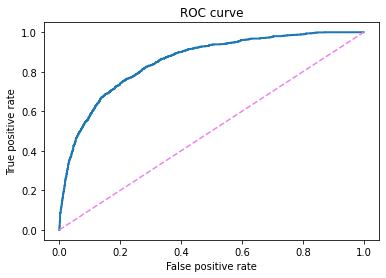

In [67]:
fpr, tpr, thresholds = roc_curve(y_val, logit.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_val, logit.predict_proba(X_val_scaled)[:,1]))

### Treating Class Imbalance

In [27]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)

X_tr_smote, y_tr_smote = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test Recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_smote.predict(X_val_scaled)), roc_auc_score(y_val, lr_smote.predict_proba(X_val_scaled)[:,1])))

Logistic Regression on SMOTE Train Data; Test Recall: 0.697, Test AUC: 0.841


### Grid Search and Class Weight for Logistic Regression

In [151]:
y = df_2.h1n1_vaccine
X = df_2.drop(labels = ['h1n1_vaccine','respondent_id','seasonal_vaccine'], axis = 1)

In [152]:
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define model
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/hyewonjeong/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.83680941 0.83678447        nan        nan        nan 0.78754635
 0.78754635 0.78754635 0.78754635        nan        nan        nan
 0.83680941 0.83678447        nan        nan        nan 0.78754635
 0.78755882 0.78755882 0.78740907        nan        nan        nan
 0.83680941 0.83678447        nan        nan        nan 0.78764616
 0.82469035 0.82469035 0.81384412        nan        nan        nan
 0.83680941 0.83678447        nan        nan        nan 0.8300571
 0.8349872  0.83494976 0.83093076        nan        nan        nan
 0.83680941 0.83678447        nan        nan        nan 0.83622279
 0.83680944 0.83687185 0.83527423        nan        nan        nan
 0.83680941 0.83678447        nan        nan        nan 0.83654735
 0.83673453 0.83669708 0.83655981        nan        nan        nan
 0.83680941 0.83678447        nan   

Best Score: 0.836871848227903
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/Users/hyewonjeong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
y = df_2.h1n1_vaccine
X = df_2.drop(labels = ['h1n1_vaccine','respondent_id','seasonal_vaccine'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

In [155]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

logit = LogisticRegression(C = 0.1, penalty= 'l2', solver = 'lbfgs')
logit.fit(X_train_scaled, y_train)

y_predict = logit.predict(X_train_scaled) 
logit.score(X_train_scaled, y_train)

0.834737564750671

In [156]:
std_scale = StandardScaler()
X_val_scaled = std_scale.fit_transform(X_val)

y_predict = logit.predict(X_val_scaled) 
logit.score(X_val_scaled, y_val)

0.8433171096967428

In [157]:
y_pred = logit.predict(X_val_scaled) 

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.8433171096967428
Precision: 0.6485411140583555
Recall: 0.46088595664467485
f1: 0.5388429752066116


In [158]:
# with class_weight for class imbalance 

std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

logit = LogisticRegression(C = 0.1, penalty= 'l2', solver = 'lbfgs', class_weight='balanced')
logit.fit(X_train_scaled, y_train)

y_predict = logit.predict(X_train_scaled) 
logit.score(X_train_scaled, y_train)

0.781688822317918

In [159]:
std_scale = StandardScaler()
X_val_scaled = std_scale.fit_transform(X_val)

y_predict = logit.predict(X_val_scaled) 
logit.score(X_val_scaled, y_val)

0.7738674653687757

In [160]:
y_pred = logit.predict(X_val_scaled) 

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.7738674653687757
Precision: 0.45668827342368884
Recall: 0.7304429783223374
f1: 0.5620014503263234


### Feature importance & Feature selection

#### Feature importance

Feature: 0, Score: -0.07531
Feature: 1, Score: 0.04564
Feature: 2, Score: 0.05487
Feature: 3, Score: -0.04940
Feature: 4, Score: 0.01194
Feature: 5, Score: 0.00215
Feature: 6, Score: -0.03563
Feature: 7, Score: -0.07814
Feature: 8, Score: 0.07052
Feature: 9, Score: 0.93515
Feature: 10, Score: -0.27781
Feature: 11, Score: 0.00086
Feature: 12, Score: 0.04865
Feature: 13, Score: 0.17181
Feature: 14, Score: -0.02093
Feature: 15, Score: 0.55611
Feature: 16, Score: 0.37108
Feature: 17, Score: 0.00405
Feature: 18, Score: 0.07284
Feature: 19, Score: 0.25883
Feature: 20, Score: -0.10925
Feature: 21, Score: 0.25689
Feature: 22, Score: -0.02359
Feature: 23, Score: -0.00775
Feature: 24, Score: 0.05503
Feature: 25, Score: 0.07463
Feature: 26, Score: 0.22439
Feature: 27, Score: 0.21214
Feature: 28, Score: 0.07053
Feature: 29, Score: -0.00135
Feature: 30, Score: 0.00443
Feature: 31, Score: -0.05932
Feature: 32, Score: -0.09227
Feature: 33, Score: -0.03449
Feature: 34, Score: 0.03619
Feature: 35, Scor

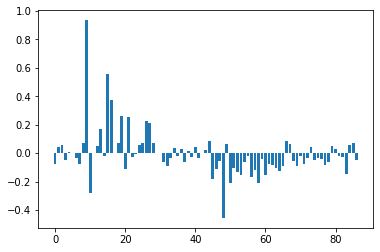

In [31]:
importance = logit.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [169]:
df_3 = df.copy()

In [170]:
y = df_3.h1n1_vaccine
X = df_3[['doctor_recc_h1n1','employment_industry','employment_occupation',
         'opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_seas_risk','age_group']]


ordinal = OrdinalEncoder()

ordinal.fit(X[['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_seas_risk','age_group']])

X[['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_seas_risk','age_group']]= \
ordinal.transform(X[['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_seas_risk','age_group']])

X = pd.get_dummies(X, columns =['doctor_recc_h1n1','employment_industry','employment_occupation'], drop_first = True)

<ipython-input-170-c6ef3f37a08e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_seas_risk','age_group']]= \
/Users/hyewonjeong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

logit_selected = LogisticRegression(C=1000) # setting C very high essentially removes regularization
logit_selected.fit(X_train_scaled, y_train)

y_predict = logit_selected.predict(X_train_scaled) 
logit_selected.score(X_train_scaled, y_train)

0.8289334082256756

In [172]:
std_scale = StandardScaler()
X_val_scaled = std_scale.fit_transform(X_val)

logit_selected = LogisticRegression(C=1000) # setting C very high essentially removes regularization
logit_selected.fit(X_val_scaled, y_val)

y_predict = logit_selected.predict(X_train_scaled) 
logit_selected.score(X_val_scaled, y_val)

0.8423811306626732

In [36]:
y_pred = logit_selected.predict(X_val_scaled) 
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.8423811306626732
Precision: 0.6718995290423861
Recall: 0.40339302544769085
f1: 0.5041224970553592


In [37]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)

X_tr_smote, y_tr_smote = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test Recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, lr_smote.predict(X_val_scaled)), roc_auc_score(y_val, lr_smote.predict_proba(X_val_scaled)[:,1])))

Logistic Regression on SMOTE Train Data; Test Recall: 0.696, Test AUC: 0.835


# Naive Bayes 

In [131]:
y = df_2.h1n1_vaccine
X = df_2.drop(labels = ['h1n1_vaccine','respondent_id','seasonal_vaccine'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

In [132]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)

nb = BernoulliNB()
nb.fit(X_train_scaled, y_train)
nb.score(X_train_scaled, y_train)

0.7907383136740935

In [133]:
std_scale = StandardScaler()
X_val_scaled = std_scale.fit_transform(X_val)

nb = BernoulliNB()
nb.fit(X_val_scaled, y_val)
nb.score(X_val_scaled, y_val)

0.8010108573567952

In [134]:
y_pred =nb.predict(X_val_scaled) 
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.8010108573567952
Precision: 0.49917898193760263
Recall: 0.5730442978322338
f1: 0.5335673541026766


In [135]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)

X_tr_smote, y_tr_smote = smote.fit_resample(X_train_scaled, y_train)

nb_smote = BernoulliNB() 
nb_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test Recall: %.3f, Test AUC: %.3f' % \
      (recall_score(y_val, nb_smote.predict(X_val_scaled)), roc_auc_score(y_val, nb_smote.predict_proba(X_val_scaled)[:,1])))

Logistic Regression on SMOTE Train Data; Test Recall: 0.687, Test AUC: 0.807


### Random Forest 

In [146]:
y = df_2.h1n1_vaccine
X = df_2.drop(labels = ['h1n1_vaccine','respondent_id','seasonal_vaccine'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

In [72]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [73]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [74]:
rf = RandomForestClassifier()

In [75]:
rf_Grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)

In [76]:
rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [77]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 10}

In [78]:
rf = RandomForestClassifier(bootstrap=True, max_depth = 4, max_features= 'sqrt',min_samples_leaf = 2, 
                            min_samples_split = 2, n_estimators= 10)

In [80]:
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.7912375959558136

In [81]:
rf.score(X_val, y_val)

0.8113066267315612

In [82]:
y_pred=rf.predict(X_val)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.8113066267315612
Precision: 0.8732394366197183
Recall: 0.058435438265786996
f1: 0.10954063604240283


In [147]:
#with class weight

rf = RandomForestClassifier(bootstrap=True, max_depth = 4, max_features= 'sqrt',min_samples_leaf = 2, 
                            min_samples_split = 2, n_estimators= 10, class_weight='balanced')

In [148]:
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.7397491106534357

In [149]:
rf.score(X_val, y_val)

0.7450393111194309

In [150]:
y_pred=rf.predict(X_val)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.7450393111194309
Precision: 0.41973333333333335
Recall: 0.7417530631479736
f1: 0.5361035422343324


### XGBoost

In [87]:
y = df_2.h1n1_vaccine
X = df_2.drop(labels = ['h1n1_vaccine','respondent_id','seasonal_vaccine'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

In [88]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [54]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [55]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [56]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

In [57]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/hyewonjeong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=Non

In [58]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [163]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [164]:
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

/Users/hyewonjeong/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8497784434874868

In [93]:
xgb.score(X_val, y_val)

0.8444402845376263

In [94]:
y_pred=xgb.predict(X_val)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("f1:",metrics.f1_score(y_val, y_pred))

Accuracy: 0.8444402845376263
Precision: 0.6501305483028721
Recall: 0.46936852026390197
f1: 0.5451559934318555


## Test scores on Holdout 

In [168]:
rf.fit(X_test, y_test)
rf.score(X_test, y_test)

0.7512167727442906

ROC AUC score =  0.7921383387662055


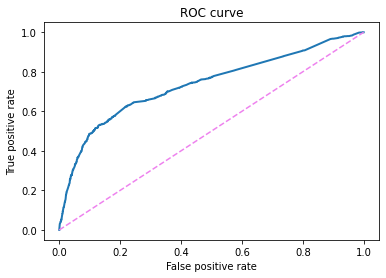

In [167]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test_scaled)[:,1]))

In [141]:
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.BuGn, annot=True, square=True, fmt='d',
           xticklabels=['non-vaccinated', 'vaccinated'],
           yticklabels=['non-vaccinated', 'vaccinated']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

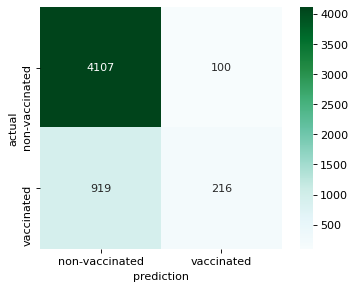

In [166]:
make_confusion_matrix(rf)

In [165]:
y_pred=rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.7368026956196181
Precision: 0.42726784755770264
Recall: 0.7013215859030837
f1: 0.5310206804536358
